### Import required libraries and data

In [3]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows= 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv('https://storage.googleapis.com/mledu-datasets/california_housing_train.csv',sep=',')

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"]/=1000.0
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4422,-118.0,34.0,39.0,2126.0,434.0,1103.0,433.0,3.3,196.2
1081,-117.1,32.8,19.0,2188.0,616.0,1304.0,607.0,2.1,114.4
3240,-117.9,33.9,25.0,3205.0,409.0,1291.0,408.0,7.2,299.2
10329,-120.1,39.4,17.0,1076.0,283.0,171.0,64.0,2.1,83.9
5160,-118.1,34.0,43.0,396.0,91.0,261.0,73.0,2.9,172.9
...,...,...,...,...,...,...,...,...,...
12214,-121.5,39.0,37.0,1244.0,247.0,484.0,157.0,2.4,77.5
10089,-119.8,36.8,10.0,5780.0,922.0,2712.0,883.0,5.6,135.5
14023,-122.0,37.0,42.0,1149.0,264.0,703.0,232.0,2.6,206.4
4487,-118.0,34.0,28.0,1617.0,507.0,1158.0,486.0,2.0,165.6


### Setup and define input function and model-training function

In [8]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    #convert pandas data into dict of np arrays
    features = {key:np.array(value) for key,value in dict(features).items()}
    
    #construct a dataset and configure batching/repeating
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    #shuffle data, if shuffle=True
    if shuffle:
        ds = ds.shuffle(buffer_size=10000)
        
    #return next_batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


def train_model(learning_rate, steps, batch_size, input_feature):
    
    periods = 10
    steps_per_period = steps/periods
    
    my_feature = input_feature
    my_feature_data = california_housing_dataframe[[my_feature]].astype('float32')
    my_label = "median_house_value"
    targets = california_housing_dataframe[my_label].astype('float32')
    
    #create input functions
    training_input_fn = lambda: my_input_fn(my_feature_data, targets, batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(my_feature_data, targets, num_epochs=1, shuffle=False)
    
    #create feature columns
    feature_columns = [tf.feature_column.numeric_column(my_feature)]
    
    #create linear regressor object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=feature_columns,
        optimizer = my_optimizer
    )
    
    #set up to plot state of our model's line each period
    plt.figure(figsize=(15,6))
    plt.subplot(1,2,1)
    plt.title("Learned Line by Period")
    plt.ylabel(my_label)
    plt.xlabel(my_feature)
    sample = california_housing_dataframe.sample(n=300)
    plt.scatter(sample[my_feature], sample[my_label])
    colors = [cm.coolwarm(x) for x in np.linspace(-1,1,periods)]
    
    #train model inside loop and periodically assess loss metrics
    print("Training model...")
    print("RMSE (on training data):")
    root_mean_squared_errors = []
    for period in range (0, periods):
        #train model, starting from prior state
        linear_regressor.train(
            input_fn = training_input_fn,
            steps = steps_per_period,
        )
        
        #take a break to compute predictions
        predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])
        
        #compute loss
        root_mean_squared_error = math.sqrt(metrics.mean_squared_error(predictions, targets))
        print(" period %02d : %0.2f" % (period, root_mean_squared_error))
        root_mean_squared_errors.append(root_mean_squared_error)
        
        #track weights and biases over time
        y_extents = np.array([0, sample[my_label].max()])
        weight = linear_regressor.get_variable_value('linear/linear_model/%s/weights' % input_feature)[0]
        bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')
        
        x_extents = (y_extents - bias) / weight
        x_extents = np.maximum(np.minimum(x_extents, sample[my_feature].max()), sample[my_feature].min())
        y_extents = weight * x_extents + bias
        plt.plot(x_extents, y_extents, color=colors[period])
    print("Model training finished")
    
    #output a graph of loss metrics over periods
    plt.subplot(1,2,2)
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title('Root Mean Squared Error vs Periods')
    plt.tight_layout()
    plt.plot(root_mean_squared_errors)
    
    #create table with calibration data
    calibration_data = pd.DataFrame()
    calibration_data["predictions"] = pd.Series(predictions)
    calibration_data['targets'] = pd.Series(targets)
    display.display(calibration_data.describe())
    
    print("Final RMSE (on training data): %0.2f" % root_mean_squared_error)
    
    return calibration_data
    

### Task: Try synthetic feature

Training model...
RMSE (on training data):
 period 00 : 199.30
 period 01 : 166.42
 period 02 : 141.75
 period 03 : 132.58
 period 04 : 131.04
 period 05 : 132.43
 period 06 : 133.09
 period 07 : 133.09
 period 08 : 132.59
 period 09 : 132.03
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,197.0,207.3
std,90.7,116.0
min,44.7,15.0
25%,161.4,119.4
50%,194.0,180.4
75%,221.6,265.0
max,4328.8,500.0


Final RMSE (on training data): 132.03


,predictions,targets
0,192.9,66.9
1,173.5,80.1
2,236.0,85.7
3,531.6,73.4
4,161.0,65.5
...,...,...
16995,242.8,111.4
16996,208.7,79.0
16997,170.1,103.6
16998,151.7,85.8


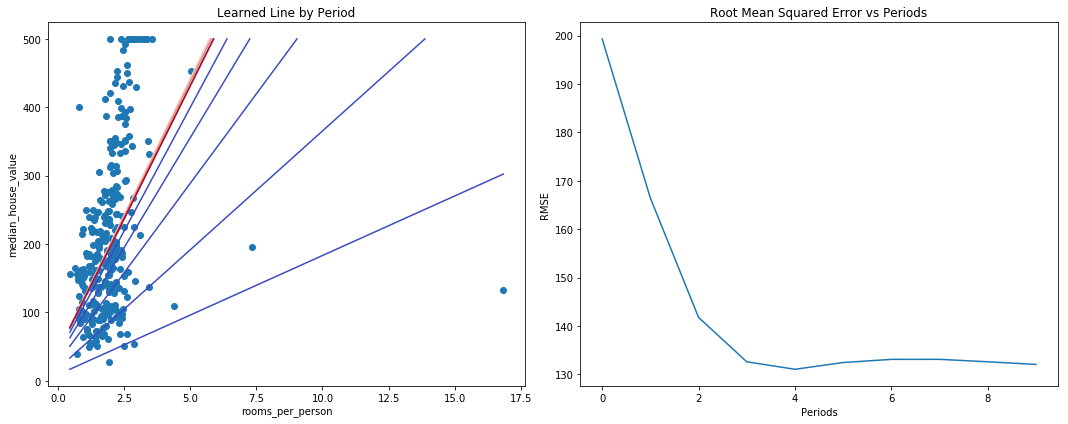

In [12]:
california_housing_dataframe["rooms_per_person"] = california_housing_dataframe["total_rooms"] / california_housing_dataframe["population"]

calibration_data = train_model(
    learning_rate = 0.05,
    steps = 800,
    batch_size = 5,
    input_feature = "rooms_per_person"
)

calibration_data

### Task: Identify outliers

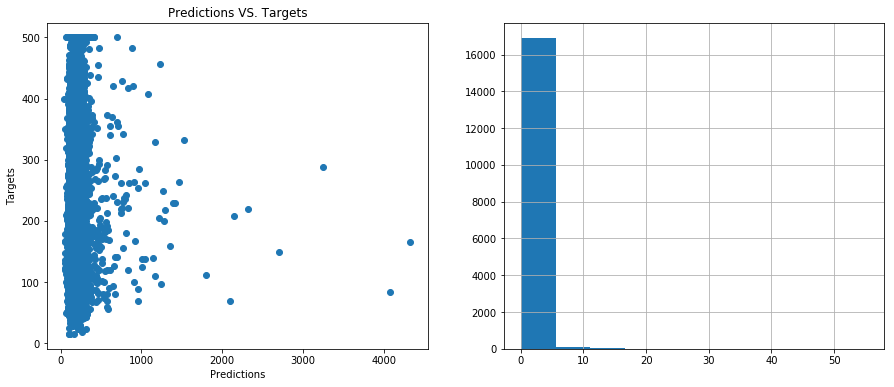

In [18]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title("Predictions VS. Targets")
plt.xlabel("Predictions")
plt.ylabel("Targets")
data = calibration_data
plt.scatter(data["predictions"], data["targets"])


plt.subplot(1,2,2)
_ = california_housing_dataframe["rooms_per_person"].hist()

### Task: Clip outliers

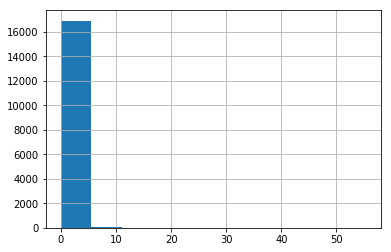

In [23]:
clipped_feature = (california_housing_dataframe["rooms_per_person"]).apply(lambda x: max(x,7))
_ = california_housing_dataframe["rooms_per_person"].hist()


Training model...
RMSE (on training data):
 period 00 : 198.65
 period 01 : 165.63
 period 02 : 141.77
 period 03 : 132.49
 period 04 : 130.68
 period 05 : 131.16
 period 06 : 132.94
 period 07 : 132.82
 period 08 : 134.12
 period 09 : 133.47
Model training finished


,predictions,targets
count,17000.0,17000.0
mean,207.7,207.3
std,94.3,116.0
min,49.4,15.0
25%,170.7,119.4
50%,204.5,180.4
75%,233.3,265.0
max,4501.4,500.0


Final RMSE (on training data): 133.47


,predictions,targets
0,203.4,66.9
1,183.3,80.1
2,248.2,85.7
3,555.4,73.4
4,170.3,65.5
...,...,...
16995,255.3,111.4
16996,219.8,79.0
16997,179.8,103.6
16998,160.6,85.8


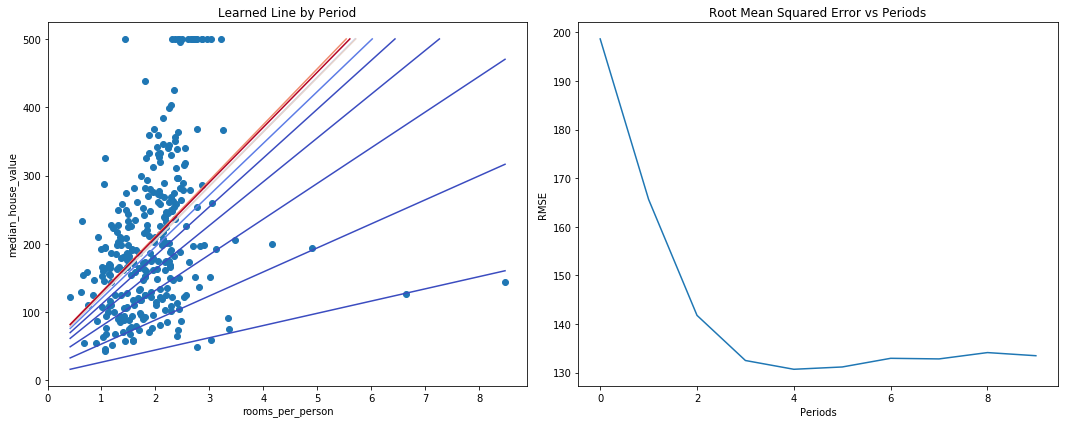

In [24]:
calibration_data = train_model(
    learning_rate = 0.05,
    steps = 800,
    batch_size = 5,
    input_feature = "rooms_per_person"
)

calibration_data



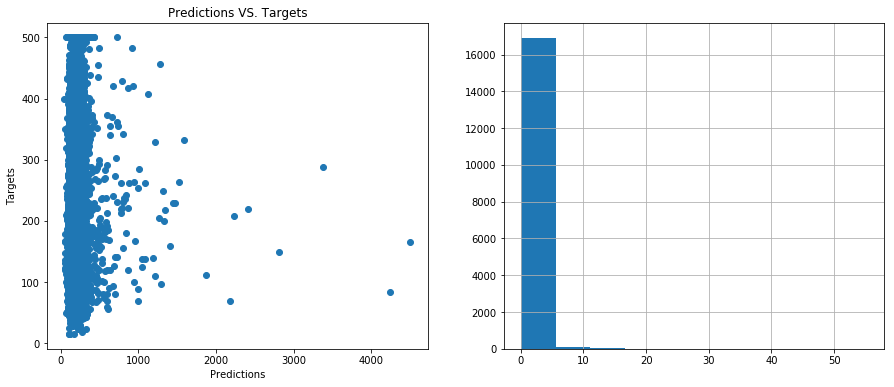

In [25]:
plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.title("Predictions VS. Targets")
plt.xlabel("Predictions")
plt.ylabel("Targets")
data = calibration_data
plt.scatter(data["predictions"], data["targets"])


plt.subplot(1,2,2)
_ = california_housing_dataframe["rooms_per_person"].hist()